In [1]:
%matplotlib inline

# Import Dependencies

In [2]:
# System & OS
import warnings
warnings.filterwarnings('ignore')
# Data Storage
from google.colab import drive
# Data Analysis
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr
# Data Visualization
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
# Miscellaneous
from decimal import Decimal

# Mount Storage

In [3]:
# Mount Google Drive to Colab Instance
drive.mount('/content/drive')
# Change directory to where the data are stored (old: %cd '/content/drive/MyDrive/Research/Ongoing/Protostellar Luminosity/Data')
%cd '/content/drive/MyDrive/Colab Notebooks/Data'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1EKq5q8_K4j5NQpcWKFDhxA77zKtxtbug/Data


# Data Visualization

In [4]:
df = pd.read_csv('master_file.csv', skiprows=1, names=['Model number',
                                                       'Class', 
                                                       'Mass ratio', 
                                                       'Timestep', 
                                                       'Inclination', 
                                                       'Wavelength (cm)', 
                                                       'Flux (erg cm^-2 s^-1)', 
                                                       'L_int (Lsun)'])
df

,Model number,Class,Mass ratio,Timestep,Inclination,Wavelength (cm),Flux (erg cm^-2 s^-1),L_int (Lsun)
0,1,0,0.034096,2,5,3.600030,1.171193e-18,0.001486
1,1,0,0.034096,2,5,2.400020,4.342741e-18,0.001486
2,1,0,0.034096,2,5,1.600013,1.734933e-17,0.001486
3,1,0,0.034096,2,5,1.300011,3.665945e-17,0.001486
4,1,0,0.034096,2,5,1.100009,6.839343e-17,0.001486
...,...,...,...,...,...,...,...,...
8993595,33,1,0.885142,379,85,0.000025,2.878049e-13,5.9644
8993596,33,1,0.885142,379,85,0.000020,1.755736e-14,5.9644
8993597,33,1,0.885142,379,85,0.000015,-1.782472e-16,5.9644
8993598,33,1,0.885142,379,85,0.000010,-1.308467e-17,5.9644


In [5]:
# Drop irrelevant columns
df.drop(columns=['Mass ratio', 'Timestep', 'Inclination'])
# Typecast objects to float64
df['L_int (Lsun)'] = df['L_int (Lsun)'].apply(lambda x: float(x))
# Add columns with logged data
df['log(Flux)'] = np.log10(df['Flux (erg cm^-2 s^-1)'].values)
df['log(L_int)'] = np.log10(df['L_int (Lsun)'].values)
df

,Model number,Class,Mass ratio,Timestep,Inclination,Wavelength (cm),Flux (erg cm^-2 s^-1),L_int (Lsun),log(Flux),log(L_int)
0,1,0,0.034096,2,5,3.600030,1.171193e-18,0.001486,-17.931371,-2.827923
1,1,0,0.034096,2,5,2.400020,4.342741e-18,0.001486,-17.362236,-2.827923
2,1,0,0.034096,2,5,1.600013,1.734933e-17,0.001486,-16.760717,-2.827923
3,1,0,0.034096,2,5,1.300011,3.665945e-17,0.001486,-16.435814,-2.827923
4,1,0,0.034096,2,5,1.100009,6.839343e-17,0.001486,-16.164986,-2.827923
...,...,...,...,...,...,...,...,...,...,...
8993595,33,1,0.885142,379,85,0.000025,2.878049e-13,5.964400,-12.540902,0.775567
8993596,33,1,0.885142,379,85,0.000020,1.755736e-14,5.964400,-13.755541,0.775567
8993597,33,1,0.885142,379,85,0.000015,-1.782472e-16,5.964400,NaN,0.775567
8993598,33,1,0.885142,379,85,0.000010,-1.308467e-17,5.964400,NaN,0.775567


In [6]:
print(f'Percentage of missing values (before handling):\n\n{round(df.isnull().sum().sort_values(ascending=False) / len(df.index) * 100, 2)}\n')
# Drop missing values and infinities
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
print(f'Percentage of missing values (after handling):\n\n{round(df.isnull().sum().sort_values(ascending=False) / len(df.index) * 100, 2)}\n')
df

Percentage of missing values (before handling):

log(Flux)                3.96
L_int (Lsun)             0.03
log(L_int)               0.03
Model number             0.00
Class                    0.00
Mass ratio               0.00
Timestep                 0.00
Inclination              0.00
Wavelength (cm)          0.00
Flux (erg cm^-2 s^-1)    0.00
dtype: float64

Percentage of missing values (after handling):

Model number             0.0
Class                    0.0
Mass ratio               0.0
Timestep                 0.0
Inclination              0.0
Wavelength (cm)          0.0
Flux (erg cm^-2 s^-1)    0.0
L_int (Lsun)             0.0
log(Flux)                0.0
log(L_int)               0.0
dtype: float64



,Model number,Class,Mass ratio,Timestep,Inclination,Wavelength (cm),Flux (erg cm^-2 s^-1),L_int (Lsun),log(Flux),log(L_int)
0,1,0,0.034096,2,5,3.600030,1.171193e-18,0.001486,-17.931371,-2.827923
1,1,0,0.034096,2,5,2.400020,4.342741e-18,0.001486,-17.362236,-2.827923
2,1,0,0.034096,2,5,1.600013,1.734933e-17,0.001486,-16.760717,-2.827923
3,1,0,0.034096,2,5,1.300011,3.665945e-17,0.001486,-16.435814,-2.827923
4,1,0,0.034096,2,5,1.100009,6.839343e-17,0.001486,-16.164986,-2.827923
...,...,...,...,...,...,...,...,...,...,...
8993592,33,1,0.885142,379,85,0.000040,1.193031e-11,5.964400,-10.923348,0.775567
8993593,33,1,0.885142,379,85,0.000035,5.392117e-12,5.964400,-11.268241,0.775567
8993594,33,1,0.885142,379,85,0.000030,1.622111e-12,5.964400,-11.789919,0.775567
8993595,33,1,0.885142,379,85,0.000025,2.878049e-13,5.964400,-12.540902,0.775567


In [7]:
with open('lin_coef.csv', 'w') as coef, open('correlation.csv', 'w') as corr:
  coef.write('Model number, Class, Wavelength (cm), Slope (erg cm^-2 s^-1 Lsun^-1), Unc_slope (erg cm^-2 s^-1 Lsun^-1), Intercept (erg cm^-2 s^-1), Unc_intercept (erg cm^-2 s^-1)\n')
  corr.write('Model number, Class, Wavelength (cm), Correlation coefficient (linear space), Correlation coefficient (log10 space)\n')
  # Store root
  root = df
  # Master plots
  # Class 0 & 1
  # Make plot
  plt.scatter(df['L_int (Lsun)'], df['Flux (erg cm^-2 s^-1)'])
  plt.title('Flux vs Internal Luminosity: Class 0 & 1')
  plt.xlabel('Internal Luminosity (L$_{sun}$)')
  plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
  plt.xscale('log')
  plt.yscale('log')

  # Fit linear regression
  df = df[df['log(L_int)'] >= 0.1]
  flux = sm.add_constant(df['log(Flux)'])
  model = sm.OLS(df['log(L_int)'], flux)
  results = model.fit()
  m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
  coef.write(f'{0}, {2}, {0}, {m}, {unc_m}, {b}, {unc_b}\n')

  # Compute correlation coefficient
  lin_corr, _ = pearsonr(df['L_int (Lsun)'], df['Flux (erg cm^-2 s^-1)'])
  log_corr, _ = pearsonr(df['log(L_int)'], df['log(Flux)'])
  corr.write(f'{0}, {2}, {0}, {lin_corr}, {log_corr}\n')

  # Visualize regression
  # L = np.linspace(1e-18, 1e5)
  # F = 10**b * L**m
  # plt.plot(L, F, color='k')
  # plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'{Decimal(val):.2e} cm'])
  plt.legend([f'All wavelengths'])

  # Save figure
  plt.savefig(f'Figures/flux_vs_lint_2_master.jpg')
  plt.clf()

  # Class 0 
  df = root
  features_0 = df[df['Class'] == 0]
  # Make plot
  plt.scatter(features_0['L_int (Lsun)'], features_0['Flux (erg cm^-2 s^-1)'])
  plt.title('Flux vs Internal Luminosity: Class 0')
  plt.xlabel('Internal Luminosity (L$_{sun}$)')
  plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
  plt.xscale('log')
  plt.yscale('log')

  # Fit linear regression
  features_0 = features_0[features_0['log(L_int)'] >= 0.1]
  flux = sm.add_constant(features_0['log(Flux)'])
  model = sm.OLS(features_0['log(L_int)'], flux)
  results = model.fit()
  m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
  coef.write(f'{0}, {0}, {0}, {m}, {unc_m}, {b}, {unc_b}\n')

  # Compute correlation coefficient
  lin_corr, _ = pearsonr(features_0['L_int (Lsun)'], features_0['Flux (erg cm^-2 s^-1)'])
  log_corr, _ = pearsonr(features_0['log(L_int)'], features_0['log(Flux)'])
  corr.write(f'{0}, {0}, {0}, {lin_corr}, {log_corr}\n')

  # Visualize regression
  # L = np.linspace(1e-18, 1e5)
  # F = 10**b * L**m
  # plt.plot(L, F, color='k')
  # plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'{Decimal(val):.2e} cm'])
  plt.legend([f'All wavelengths'])

  # Save figure
  plt.savefig(f'Figures/flux_vs_lint_0_master.jpg')
  plt.clf()

  # Class 1
  df = root
  features_1 = df[df['Class'] == 1]
  # Make plot
  plt.scatter(features_1['L_int (Lsun)'], features_1['Flux (erg cm^-2 s^-1)'])
  plt.title('Flux vs Internal Luminosity: Class 1')
  plt.xlabel('Internal Luminosity (L$_{sun}$)')
  plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
  plt.xscale('log')
  plt.yscale('log')

  # Fit linear regression
  features_1 = features_1[features_1['log(L_int)'] >= 0.1]
  flux = sm.add_constant(features_1['log(Flux)'])
  model = sm.OLS(features_1['log(L_int)'], flux)
  results = model.fit()
  m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
  coef.write(f'{0}, {1}, {0}, {m}, {unc_m}, {b}, {unc_b}\n')

  # Compute correlation coefficient
  lin_corr, _ = pearsonr(features_1['L_int (Lsun)'], features_1['Flux (erg cm^-2 s^-1)'])
  log_corr, _ = pearsonr(features_1['log(L_int)'], features_1['log(Flux)'])
  corr.write(f'{0}, {1}, {0}, {lin_corr}, {log_corr}\n')

  # Visualize regression
  # L = np.linspace(1e-18, 1e5)
  # F = 10**b * L**m
  # plt.plot(L, F, color='k')
  # plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'{Decimal(val):.2e} cm'])
  plt.legend([f'All wavelengths'])

  # Save figure
  plt.savefig(f'Figures/flux_vs_lint_1_master.jpg')
  plt.clf()

  # Split by wavelength
  df = root
  for idx, val in enumerate(df['Wavelength (cm)'].unique()):
    # Class 0 & 1
    features = df[df['Wavelength (cm)'] == val]
    tmp = features
    # Make plot
    plt.scatter(features['L_int (Lsun)'], features['Flux (erg cm^-2 s^-1)'])
    plt.title('Flux vs Internal Luminosity: Class 0 & 1')
    plt.xlabel('Internal Luminosity (L$_{sun}$)')
    plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')

    # Fit linear regression
    features = features[features['log(L_int)'] >= 0.1]
    flux = sm.add_constant(features['log(Flux)'])
    model = sm.OLS(features['log(L_int)'], flux)
    results = model.fit()
    m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
    coef.write(f'{0}, {2}, {val}, {m}, {unc_m}, {b}, {unc_b}\n')

    # Compute correlation coefficient
    lin_corr, _ = pearsonr(features['L_int (Lsun)'], features['Flux (erg cm^-2 s^-1)'])
    log_corr, _ = pearsonr(features['log(L_int)'], features['log(Flux)'])
    corr.write(f'{0}, {2}, {val}, {lin_corr}, {log_corr}\n')

    # Visualize regression
    # L = np.linspace(1e-18, 1e5)
    # F = 10**b * L**m
    # plt.plot(L, F, color='k')
    # plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'{Decimal(val):.2e} cm'])
    plt.legend([f'{Decimal(val):.2e} cm'])

    # Save figure
    plt.savefig(f'Figures/flux_vs_lint_2_{Decimal(val):.2e}.jpg')
    plt.clf()

    # Class 0 
    features = tmp
    features_0 = features[features['Class'] == 0]
    # Make plot
    plt.scatter(features_0['L_int (Lsun)'], features_0['Flux (erg cm^-2 s^-1)'])
    plt.title('Flux vs Internal Luminosity: Class 0')
    plt.xlabel('Internal Luminosity (L$_{sun}$)')
    plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')

    # Fit linear regression
    features_0 = features_0[features_0['log(L_int)'] >= 0.1]
    flux = sm.add_constant(features_0['log(Flux)'])
    model = sm.OLS(features_0['log(L_int)'], flux)
    results = model.fit()
    m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
    coef.write(f'{0}, {0}, {val}, {m}, {unc_m}, {b}, {unc_b}\n')

    # Compute correlation coefficient
    lin_corr, _ = pearsonr(features_0['L_int (Lsun)'], features_0['Flux (erg cm^-2 s^-1)'])
    log_corr, _ = pearsonr(features_0['log(L_int)'], features_0['log(Flux)'])
    corr.write(f'{0}, {0}, {val}, {lin_corr}, {log_corr}\n')

    # Visualize regression
    # L = np.linspace(1e-18, 1e5)
    # F = 10**b * L**m
    # plt.plot(L, F, color='k')
    # plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'{Decimal(val):.2e} cm'])
    plt.legend([f'{Decimal(val):.2e} cm'])

    # Save figure
    plt.savefig(f'Figures/flux_vs_lint_0_{Decimal(val):.2e}.jpg')
    plt.clf()

    # Class 1
    features = tmp
    features_1 = features[features['Class'] == 1]
    # Make plot
    plt.scatter(features_1['L_int (Lsun)'], features_1['Flux (erg cm^-2 s^-1)'])
    plt.title('Flux vs Internal Luminosity: Class 1')
    plt.xlabel('Internal Luminosity (L$_{sun}$)')
    plt.ylabel('Flux (erg cm$^{-2}$ s$^{-1}$)')
    plt.xscale('log')
    plt.yscale('log')

    # Fit linear regression
    features_1 = features_1[features_1['log(L_int)'] >= 0.1]
    flux = sm.add_constant(features_1['log(Flux)'])
    model = sm.OLS(features_1['log(L_int)'], flux)
    results = model.fit()
    m, unc_m, b, unc_b = results.params[1], results.bse[1], results.params[0], results.bse[0]
    coef.write(f'{0}, {1}, {val}, {m}, {unc_m}, {b}, {unc_b}\n')

    # Compute correlation coefficient
    lin_corr, _ = pearsonr(features_1['L_int (Lsun)'], features_1['Flux (erg cm^-2 s^-1)'])
    log_corr, _ = pearsonr(features_1['log(L_int)'], features_1['log(Flux)'])
    corr.write(f'{0}, {1}, {val}, {lin_corr}, {log_corr}\n')

    # Visualize regression
    # L = np.linspace(1e-18, 1e5)
    # F = 10**b * L**m
    # plt.plot(L, F, color='k')
    # plt.legend([f'$y = 10^{{{b:.3f}}} \cdot x^{{{m:.3f}}}$', f'{Decimal(val):.2e} cm'])
    plt.legend([f'{Decimal(val):.2e} cm'])

    # Save figure
    plt.savefig(f'Figures/flux_vs_lint_1_{Decimal(val):.2e}.jpg')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [8]:
min = 0
val = 0
for _ in df['Wavelength (cm)']:
  if min == 0 or np.abs(70e-4 - _) < min:
    min = np.abs(70e-4 - _)
    val = _ 
print(val)

0.0073570602450168


In [9]:
print(f'{Decimal(val):.2e}')

7.36e-3


In [22]:
lin_coef = pd.read_csv('lin_coef.csv', skiprows=1, names=['Model number', 
                                                          'Class', 
                                                          'Wavelength (cm)', 
                                                          'Slope (erg cm^-2 s^-1 Lsun^-1)', 
                                                          'Unc_slope (erg cm^-2 s^-1 Lsun^-1)', 
                                                          'Intercept (erg cm^-2 s^-1)', 
                                                          'Unc_intercept (erg cm^-2 s^-1)'])
corr = pd.read_csv('correlation.csv', skiprows=1, names=['Model number', 
                                                         'Class', 
                                                         'Wavelength (cm)', 
                                                         'Correlation coefficient (linear space)', 
                                                         'Correlation coefficient (log10 space)'])

lin_coef = lin_coef[lin_coef['Wavelength (cm)'] == val]
corr = corr[corr['Wavelength (cm)'] == val]

lin_coef

,Model number,Class,Wavelength (cm),Slope (erg cm^-2 s^-1 Lsun^-1),Unc_slope (erg cm^-2 s^-1 Lsun^-1),Intercept (erg cm^-2 s^-1),Unc_intercept (erg cm^-2 s^-1)
81,0,2,0.007357,0.766824,0.001173,7.446168,0.009955
82,0,0,0.007357,0.965759,0.001855,8.861767,0.014778
83,0,1,0.007357,0.787212,0.001311,7.658892,0.011271


In [23]:
corr

,Model number,Class,Wavelength (cm),Correlation coefficient (linear space),Correlation coefficient (log10 space)
81,0,2,0.007357,0.798835,0.926986
82,0,0,0.007357,0.919423,0.976716
83,0,1,0.007357,0.851504,0.929423


In [46]:
lin_coef = pd.read_csv('lin_coef.csv', skiprows=1, names=['Model number', 
                                                          'Class', 
                                                          'Wavelength (microns)', 
                                                          'Slope (erg cm^-2 s^-1 Lsun^-1)', 
                                                          'Unc_slope (erg cm^-2 s^-1 Lsun^-1)', 
                                                          'Intercept (erg cm^-2 s^-1)', 
                                                          'Unc_intercept (erg cm^-2 s^-1)'])
corr = pd.read_csv('correlation.csv', skiprows=1, names=['Model number', 
                                                         'Class', 
                                                         'Wavelength (microns)', 
                                                         'Correlation coefficient (linear space)', 
                                                         'Correlation coefficient (log10 space)'])

lin_coef['Wavelength (microns)'] = lin_coef['Wavelength (microns)'].apply(lambda x: x * 1e4)
corr['Wavelength (microns)'] = corr['Wavelength (microns)'].apply(lambda x: x * 1e4)

corr_lin = corr[corr['Correlation coefficient (linear space)'] >= 0.7]
corr_log = corr[corr['Correlation coefficient (log10 space)'] >= 0.7]

In [47]:
corr_lin

,Model number,Class,Wavelength (microns),Correlation coefficient (linear space),Correlation coefficient (log10 space)
58,0,0,350.002869,0.712787,0.956486
61,0,0,226.001857,0.765141,0.969787
64,0,0,184.801511,0.796159,0.975369
67,0,0,158.501296,0.822657,0.979168
70,0,0,135.901112,0.850091,0.982131
...,...,...,...,...,...
291,0,2,1.166010,0.727876,0.212018
293,0,1,1.166010,0.729500,0.328024
297,0,2,2.154018,0.847336,0.303742
298,0,0,2.154018,0.768008,0.482888


In [48]:
corr_log

,Model number,Class,Wavelength (microns),Correlation coefficient (linear space),Correlation coefficient (log10 space)
3,0,2,36000.295167,0.255545,0.830435
4,0,0,36000.295167,0.614285,0.904546
5,0,1,36000.295167,0.309368,0.835624
6,0,2,24000.196778,0.255898,0.830865
7,0,0,24000.196778,0.614499,0.905094
...,...,...,...,...,...
136,0,0,11.660095,0.871130,0.795806
139,0,0,11.220092,0.866592,0.785619
142,0,0,10.800089,0.863792,0.780051
145,0,0,10.390085,0.859240,0.772150


In [50]:
corr_lin['Wavelength (microns)'].nunique()

62

In [51]:
corr_log['Wavelength (microns)'].nunique()

49

In [57]:
corr_lin_0, corr_lin_1 = corr_lin[corr_lin['Class'] == 0], corr_lin[corr_lin['Class'] == 1]
corr_log_0, corr_log_1 = corr_log[corr_log['Class'] == 0], corr_log[corr_log['Class'] == 1]

In [59]:
corr_lin_0.shape

(60, 5)

In [60]:
corr_lin_0['Wavelength (microns)'].nunique()

60

In [61]:
corr_lin_1.shape

(57, 5)

In [62]:
corr_lin_1['Wavelength (microns)'].nunique()

57

In [63]:
corr_log_0.shape

(49, 5)

In [64]:
corr_log_0['Wavelength (microns)'].nunique()

49

In [65]:
corr_log_1.shape

(37, 5)

In [66]:
corr_log_1['Wavelength (microns)'].nunique()

37

Text(0.5, 1.0, 'Wavelengths (microns) with correlation coefficient >= 0.7\nClass 0, Linear space')

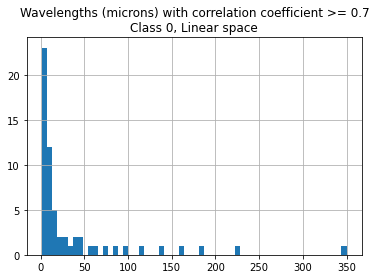

In [75]:
corr_lin_0.hist(column=['Wavelength (microns)'], bins=corr_lin_0['Wavelength (microns)'].nunique())
plt.title('Wavelengths (microns) with correlation coefficient >= 0.7\n(Class 0, Linear space)')

Text(0.5, 1.0, 'Wavelengths (microns) with correlation coefficient >= 0.7\n(Class 1, Linear space)')

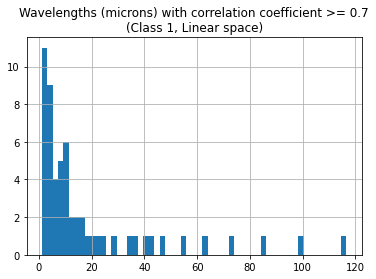

In [76]:
corr_lin_1.hist(column=['Wavelength (microns)'], bins=corr_lin_1['Wavelength (microns)'].nunique())
plt.title('Wavelengths (microns) with correlation coefficient >= 0.7\n(Class 1, Linear space)')

Text(0.5, 1.0, 'Wavelengths (microns) with correlation coefficient >= 0.7\n(Class 0, Log10 space)')

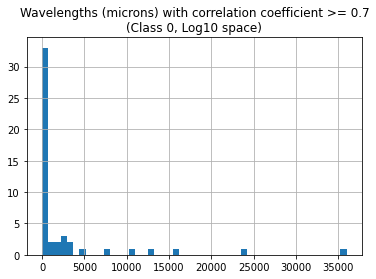

In [77]:
corr_log_0.hist(column=['Wavelength (microns)'], bins=corr_log_0['Wavelength (microns)'].nunique())
plt.title('Wavelengths (microns) with correlation coefficient >= 0.7\n(Class 0, Log10 space)')

Text(0.5, 1.0, 'Wavelengths (microns) with correlation coefficient >= 0.7\n(Class 1, Log10 space)')

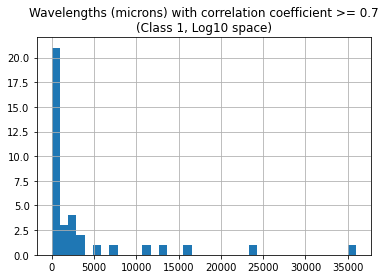

In [78]:
corr_log_1.hist(column=['Wavelength (microns)'], bins=corr_log_1['Wavelength (microns)'].nunique())
plt.title('Wavelengths (microns) with correlation coefficient >= 0.7\n(Class 1, Log10 space)')